# AnoGAN  - CFRP
- 2020.08.11 : Genrator 학습 수 ... 4

# 개발일지
- 2020.08.14 : 분율 추출 구현
- 2020.08.15 : 이상치 상관계수 추출 구현 / 모델 save, load 구현
- 2020.08.16 : anomaly detect 이미지 저장 구현 / 티티늄(Ti64) 상대 밀도 계산 구현

--- 

# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100 # z벡터의 잠재공간(latent space)의 크기
workers = 4 # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 1e-5

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
data_root = "../../OhSeHyeon/source/dataset/aug_train"

data_set = dataset.ImageFolder(root = data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 920
device : cuda:0


# MODEL

In [4]:
# Generative Adversarial Networks Model

# === Generator 모델 ===
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def G_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.G_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *G_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *G_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *G_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *G_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.G_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1 , 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.G_gen_distribution(input)
        fake_img = self.G_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, BN=True):
            if BN:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            return block
        
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, BN=False),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, BN=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, BN=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, BN=True)
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature

# Loss & Optim

In [5]:
# G and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,G 네트워크 모델 객체 선언
D = Discriminator().to(device)
G = Generator().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
G.apply(weights_init)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 G로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 G에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(G)

def reset_grad():
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

---

# Train DCGAN

In [6]:
img_list = []
G_losses = []
D_losses = []
iters = 0

def train(epoch, learning_G_per_D):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train Discriminator
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = G(z)
        fake_classification, _ = D(fake_img) # output = D(G(z))
        fake_loss = criterion(fake_classification, fake_labels) # D(G(z))=0일 때의 loss
        fake_score = fake_classification
        D_G_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss 
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(G(z))=0이어야 D가 최적

        
        # Train Generater
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_G_per_D):
            fake_img = G(z)
            fake_classification, _ = D(fake_img)  # output : D(G(z))
            D_G_z2 = fake_classification.mean().item()
            G_loss = criterion(fake_classification, real_labels) # D(G(z))=1일 때의 loss=log(D(G(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            G_loss.backward()
            G_optimizer.step() # D(G(z))=1 이어야 G가 최적
            # ==> D(G(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / G_loss : %.4f\n- D(x) : %.4f / D(G(z1)) : %.4f / D(G(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     G_loss.item(),D_x,D_G_z1,D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = G(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(G.state_dict(), 'G.ckpt')
#torch.save(D.state_dict(), 'D.ckpt')

In [7]:
for epoch in range(epochs):
    train(epoch, learning_G_per_D = 4)

/home/piai/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/14]
- D_loss : 1.3853 / G_loss : 0.6885
- D(x) : 0.5007 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.5023
[1/100][1/14]
- D_loss : 1.3853 / G_loss : 0.6866
- D(x) : 0.5017 / D(G(z1)) : 0.5011 / D(G(z2)) : 0.5033
[1/100][2/14]
- D_loss : 1.3856 / G_loss : 0.6851
- D(x) : 0.5022 / D(G(z1)) : 0.5018 / D(G(z2)) : 0.5041
[1/100][3/14]
- D_loss : 1.3872 / G_loss : 0.6822
- D(x) : 0.5028 / D(G(z1)) : 0.5032 / D(G(z2)) : 0.5055
[1/100][4/14]
- D_loss : 1.3902 / G_loss : 0.6789
- D(x) : 0.5030 / D(G(z1)) : 0.5049 / D(G(z2)) : 0.5072
[1/100][5/14]
- D_loss : 1.3921 / G_loss : 0.6767
- D(x) : 0.5033 / D(G(z1)) : 0.5061 / D(G(z2)) : 0.5083
[1/100][6/14]
- D_loss : 1.3930 / G_loss : 0.6745
- D(x) : 0.5040 / D(G(z1)) : 0.5073 / D(G(z2)) : 0.5094
[1/100][7/14]
- D_loss : 1.3950 / G_loss : 0.6722
- D(x) : 0.5044 / D(G(z1)) : 0.5086 / D(G(z2)) : 0.5106
[1/100][8/14]
- D_loss : 1.3938 / G_loss : 0.6711
- D(x) : 0.5056 / D(G(z1)) : 0.5092 / D(G(z2)) : 0.5112
[1/100][9/14]
- D_loss : 1.3965 / G_loss : 0.6

[6/100][8/14]
- D_loss : 1.3589 / G_loss : 0.6635
- D(x) : 0.5304 / D(G(z1)) : 0.5155 / D(G(z2)) : 0.5151
[6/100][9/14]
- D_loss : 1.3559 / G_loss : 0.6631
- D(x) : 0.5323 / D(G(z1)) : 0.5157 / D(G(z2)) : 0.5153
[6/100][10/14]
- D_loss : 1.3597 / G_loss : 0.6644
- D(x) : 0.5296 / D(G(z1)) : 0.5151 / D(G(z2)) : 0.5146
[6/100][11/14]
- D_loss : 1.3519 / G_loss : 0.6658
- D(x) : 0.5330 / D(G(z1)) : 0.5144 / D(G(z2)) : 0.5139
[6/100][12/14]
- D_loss : 1.3547 / G_loss : 0.6656
- D(x) : 0.5316 / D(G(z1)) : 0.5145 / D(G(z2)) : 0.5140
[6/100][13/14]
- D_loss : 1.3491 / G_loss : 0.6670
- D(x) : 0.5338 / D(G(z1)) : 0.5138 / D(G(z2)) : 0.5132
[7/100][0/14]
- D_loss : 1.3534 / G_loss : 0.6665
- D(x) : 0.5318 / D(G(z1)) : 0.5141 / D(G(z2)) : 0.5135
[7/100][1/14]
- D_loss : 1.3478 / G_loss : 0.6666
- D(x) : 0.5346 / D(G(z1)) : 0.5139 / D(G(z2)) : 0.5134
[7/100][2/14]
- D_loss : 1.3504 / G_loss : 0.6680
- D(x) : 0.5324 / D(G(z1)) : 0.5132 / D(G(z2)) : 0.5127
[7/100][3/14]
- D_loss : 1.3455 / G_loss :

[12/100][2/14]
- D_loss : 1.2714 / G_loss : 0.7017
- D(x) : 0.5581 / D(G(z1)) : 0.4972 / D(G(z2)) : 0.4957
[12/100][3/14]
- D_loss : 1.2846 / G_loss : 0.7015
- D(x) : 0.5507 / D(G(z1)) : 0.4972 / D(G(z2)) : 0.4958
[12/100][4/14]
- D_loss : 1.2685 / G_loss : 0.7016
- D(x) : 0.5595 / D(G(z1)) : 0.4970 / D(G(z2)) : 0.4958
[12/100][5/14]
- D_loss : 1.2780 / G_loss : 0.7013
- D(x) : 0.5541 / D(G(z1)) : 0.4970 / D(G(z2)) : 0.4959
[12/100][6/14]
- D_loss : 1.2798 / G_loss : 0.7006
- D(x) : 0.5533 / D(G(z1)) : 0.4972 / D(G(z2)) : 0.4963
[12/100][7/14]
- D_loss : 1.2762 / G_loss : 0.6994
- D(x) : 0.5562 / D(G(z1)) : 0.4979 / D(G(z2)) : 0.4969
[12/100][8/14]
- D_loss : 1.2842 / G_loss : 0.6987
- D(x) : 0.5522 / D(G(z1)) : 0.4984 / D(G(z2)) : 0.4972
[12/100][9/14]
- D_loss : 1.2837 / G_loss : 0.6982
- D(x) : 0.5529 / D(G(z1)) : 0.4987 / D(G(z2)) : 0.4975
[12/100][10/14]
- D_loss : 1.2742 / G_loss : 0.6975
- D(x) : 0.5582 / D(G(z1)) : 0.4989 / D(G(z2)) : 0.4978
[12/100][11/14]
- D_loss : 1.2741 / 

[17/100][10/14]
- D_loss : 1.1661 / G_loss : 0.7908
- D(x) : 0.5726 / D(G(z1)) : 0.4556 / D(G(z2)) : 0.4535
[17/100][11/14]
- D_loss : 1.1624 / G_loss : 0.7915
- D(x) : 0.5746 / D(G(z1)) : 0.4554 / D(G(z2)) : 0.4532
[17/100][12/14]
- D_loss : 1.1601 / G_loss : 0.7929
- D(x) : 0.5755 / D(G(z1)) : 0.4548 / D(G(z2)) : 0.4525
[17/100][13/14]
- D_loss : 1.1698 / G_loss : 0.7938
- D(x) : 0.5694 / D(G(z1)) : 0.4544 / D(G(z2)) : 0.4521
[18/100][0/14]
- D_loss : 1.1606 / G_loss : 0.7937
- D(x) : 0.5745 / D(G(z1)) : 0.4543 / D(G(z2)) : 0.4522
[18/100][1/14]
- D_loss : 1.1570 / G_loss : 0.7944
- D(x) : 0.5765 / D(G(z1)) : 0.4540 / D(G(z2)) : 0.4518
[18/100][2/14]
- D_loss : 1.1725 / G_loss : 0.7959
- D(x) : 0.5668 / D(G(z1)) : 0.4534 / D(G(z2)) : 0.4512
[18/100][3/14]
- D_loss : 1.1603 / G_loss : 0.7965
- D(x) : 0.5736 / D(G(z1)) : 0.4534 / D(G(z2)) : 0.4509
[18/100][4/14]
- D_loss : 1.1549 / G_loss : 0.7987
- D(x) : 0.5760 / D(G(z1)) : 0.4525 / D(G(z2)) : 0.4499
[18/100][5/14]
- D_loss : 1.1609 

[23/100][4/14]
- D_loss : 1.0463 / G_loss : 0.9043
- D(x) : 0.5945 / D(G(z1)) : 0.4083 / D(G(z2)) : 0.4048
[23/100][5/14]
- D_loss : 1.0576 / G_loss : 0.9083
- D(x) : 0.5860 / D(G(z1)) : 0.4066 / D(G(z2)) : 0.4032
[23/100][6/14]
- D_loss : 1.0439 / G_loss : 0.9104
- D(x) : 0.5931 / D(G(z1)) : 0.4055 / D(G(z2)) : 0.4024
[23/100][7/14]
- D_loss : 1.0663 / G_loss : 0.9121
- D(x) : 0.5789 / D(G(z1)) : 0.4045 / D(G(z2)) : 0.4017
[23/100][8/14]
- D_loss : 1.0651 / G_loss : 0.9144
- D(x) : 0.5784 / D(G(z1)) : 0.4035 / D(G(z2)) : 0.4008
[23/100][9/14]
- D_loss : 1.0624 / G_loss : 0.9160
- D(x) : 0.5796 / D(G(z1)) : 0.4029 / D(G(z2)) : 0.4001
[23/100][10/14]
- D_loss : 1.0385 / G_loss : 0.9186
- D(x) : 0.5928 / D(G(z1)) : 0.4021 / D(G(z2)) : 0.3991
[23/100][11/14]
- D_loss : 1.0316 / G_loss : 0.9224
- D(x) : 0.5956 / D(G(z1)) : 0.4007 / D(G(z2)) : 0.3976
[23/100][12/14]
- D_loss : 1.0443 / G_loss : 0.9252
- D(x) : 0.5869 / D(G(z1)) : 0.3995 / D(G(z2)) : 0.3965
[23/100][13/14]
- D_loss : 1.0552 

[28/100][12/14]
- D_loss : 0.9288 / G_loss : 1.0508
- D(x) : 0.6125 / D(G(z1)) : 0.3536 / D(G(z2)) : 0.3496
[28/100][13/14]
- D_loss : 0.9041 / G_loss : 1.0596
- D(x) : 0.6249 / D(G(z1)) : 0.3509 / D(G(z2)) : 0.3466
[29/100][0/14]
- D_loss : 0.8954 / G_loss : 1.0691
- D(x) : 0.6276 / D(G(z1)) : 0.3478 / D(G(z2)) : 0.3433
[29/100][1/14]
- D_loss : 0.9000 / G_loss : 1.0772
- D(x) : 0.6212 / D(G(z1)) : 0.3445 / D(G(z2)) : 0.3406
[29/100][2/14]
- D_loss : 0.9185 / G_loss : 1.0823
- D(x) : 0.6072 / D(G(z1)) : 0.3418 / D(G(z2)) : 0.3388
[29/100][3/14]
- D_loss : 0.9088 / G_loss : 1.0869
- D(x) : 0.6120 / D(G(z1)) : 0.3401 / D(G(z2)) : 0.3372
[29/100][4/14]
- D_loss : 0.9091 / G_loss : 1.0909
- D(x) : 0.6099 / D(G(z1)) : 0.3385 / D(G(z2)) : 0.3359
[29/100][5/14]
- D_loss : 0.9187 / G_loss : 1.0946
- D(x) : 0.6033 / D(G(z1)) : 0.3372 / D(G(z2)) : 0.3347
[29/100][6/14]
- D_loss : 0.8913 / G_loss : 1.0991
- D(x) : 0.6185 / D(G(z1)) : 0.3357 / D(G(z2)) : 0.3332
[29/100][7/14]
- D_loss : 0.8824 / 

[34/100][6/14]
- D_loss : 0.8536 / G_loss : 1.1055
- D(x) : 0.6414 / D(G(z1)) : 0.3344 / D(G(z2)) : 0.3310
[34/100][7/14]
- D_loss : 0.8966 / G_loss : 1.1077
- D(x) : 0.6133 / D(G(z1)) : 0.3329 / D(G(z2)) : 0.3303
[34/100][8/14]
- D_loss : 0.8941 / G_loss : 1.1070
- D(x) : 0.6142 / D(G(z1)) : 0.3326 / D(G(z2)) : 0.3306
[34/100][9/14]
- D_loss : 0.8552 / G_loss : 1.1097
- D(x) : 0.6382 / D(G(z1)) : 0.3321 / D(G(z2)) : 0.3297
[34/100][10/14]
- D_loss : 0.8937 / G_loss : 1.1088
- D(x) : 0.6150 / D(G(z1)) : 0.3322 / D(G(z2)) : 0.3299
[34/100][11/14]
- D_loss : 0.8410 / G_loss : 1.1095
- D(x) : 0.6469 / D(G(z1)) : 0.3319 / D(G(z2)) : 0.3297
[34/100][12/14]
- D_loss : 0.8102 / G_loss : 1.1112
- D(x) : 0.6680 / D(G(z1)) : 0.3321 / D(G(z2)) : 0.3292
[34/100][13/14]
- D_loss : 0.8428 / G_loss : 1.1101
- D(x) : 0.6466 / D(G(z1)) : 0.3319 / D(G(z2)) : 0.3296
[35/100][0/14]
- D_loss : 0.8922 / G_loss : 1.1064
- D(x) : 0.6153 / D(G(z1)) : 0.3324 / D(G(z2)) : 0.3308
[35/100][1/14]
- D_loss : 0.8573 

[40/100][0/14]
- D_loss : 0.8665 / G_loss : 1.1293
- D(x) : 0.6318 / D(G(z1)) : 0.3330 / D(G(z2)) : 0.3233
[40/100][1/14]
- D_loss : 0.8267 / G_loss : 1.1569
- D(x) : 0.6517 / D(G(z1)) : 0.3270 / D(G(z2)) : 0.3144
[40/100][2/14]
- D_loss : 0.8505 / G_loss : 1.1753
- D(x) : 0.6278 / D(G(z1)) : 0.3182 / D(G(z2)) : 0.3087
[40/100][3/14]
- D_loss : 0.8051 / G_loss : 1.1932
- D(x) : 0.6510 / D(G(z1)) : 0.3121 / D(G(z2)) : 0.3032
[40/100][4/14]
- D_loss : 0.8335 / G_loss : 1.2019
- D(x) : 0.6272 / D(G(z1)) : 0.3061 / D(G(z2)) : 0.3006
[40/100][5/14]
- D_loss : 0.7854 / G_loss : 1.2086
- D(x) : 0.6557 / D(G(z1)) : 0.3037 / D(G(z2)) : 0.2986
[40/100][6/14]
- D_loss : 0.7656 / G_loss : 1.2138
- D(x) : 0.6670 / D(G(z1)) : 0.3018 / D(G(z2)) : 0.2971
[40/100][7/14]
- D_loss : 0.7829 / G_loss : 1.2126
- D(x) : 0.6547 / D(G(z1)) : 0.3008 / D(G(z2)) : 0.2974
[40/100][8/14]
- D_loss : 0.7876 / G_loss : 1.2048
- D(x) : 0.6523 / D(G(z1)) : 0.3014 / D(G(z2)) : 0.2997
[40/100][9/14]
- D_loss : 0.7800 / G_

[45/100][8/14]
- D_loss : 0.8340 / G_loss : 1.1486
- D(x) : 0.6409 / D(G(z1)) : 0.3190 / D(G(z2)) : 0.3177
[45/100][9/14]
- D_loss : 0.8501 / G_loss : 1.1820
- D(x) : 0.6275 / D(G(z1)) : 0.3169 / D(G(z2)) : 0.3071
[45/100][10/14]
- D_loss : 0.9820 / G_loss : 1.1241
- D(x) : 0.5492 / D(G(z1)) : 0.3111 / D(G(z2)) : 0.3257
[45/100][11/14]
- D_loss : 0.8203 / G_loss : 1.1505
- D(x) : 0.6613 / D(G(z1)) : 0.3295 / D(G(z2)) : 0.3175
[45/100][12/14]
- D_loss : 0.8255 / G_loss : 1.1863
- D(x) : 0.6483 / D(G(z1)) : 0.3209 / D(G(z2)) : 0.3061
[45/100][13/14]
- D_loss : 0.8004 / G_loss : 1.2302
- D(x) : 0.6475 / D(G(z1)) : 0.3021 / D(G(z2)) : 0.2928
[46/100][0/14]
- D_loss : 0.8431 / G_loss : 1.2217
- D(x) : 0.6160 / D(G(z1)) : 0.2974 / D(G(z2)) : 0.2954
[46/100][1/14]
- D_loss : 0.8228 / G_loss : 1.2140
- D(x) : 0.6277 / D(G(z1)) : 0.2976 / D(G(z2)) : 0.2976
[46/100][2/14]
- D_loss : 0.8156 / G_loss : 1.1984
- D(x) : 0.6368 / D(G(z1)) : 0.2986 / D(G(z2)) : 0.3025
[46/100][3/14]
- D_loss : 0.8600 

[51/100][2/14]
- D_loss : 0.7434 / G_loss : 1.3663
- D(x) : 0.6367 / D(G(z1)) : 0.2501 / D(G(z2)) : 0.2561
[51/100][3/14]
- D_loss : 0.6771 / G_loss : 1.3558
- D(x) : 0.6907 / D(G(z1)) : 0.2603 / D(G(z2)) : 0.2589
[51/100][4/14]
- D_loss : 0.6652 / G_loss : 1.3726
- D(x) : 0.6962 / D(G(z1)) : 0.2581 / D(G(z2)) : 0.2550
[51/100][5/14]
- D_loss : 0.6526 / G_loss : 1.3838
- D(x) : 0.7049 / D(G(z1)) : 0.2593 / D(G(z2)) : 0.2521
[51/100][6/14]
- D_loss : 0.6113 / G_loss : 1.4157
- D(x) : 0.7313 / D(G(z1)) : 0.2546 / D(G(z2)) : 0.2442
[51/100][7/14]
- D_loss : 0.6131 / G_loss : 1.4507
- D(x) : 0.7202 / D(G(z1)) : 0.2434 / D(G(z2)) : 0.2358
[51/100][8/14]
- D_loss : 0.6034 / G_loss : 1.4588
- D(x) : 0.7223 / D(G(z1)) : 0.2386 / D(G(z2)) : 0.2340
[51/100][9/14]
- D_loss : 0.6061 / G_loss : 1.4621
- D(x) : 0.7167 / D(G(z1)) : 0.2346 / D(G(z2)) : 0.2332
[51/100][10/14]
- D_loss : 0.6376 / G_loss : 1.4563
- D(x) : 0.6927 / D(G(z1)) : 0.2330 / D(G(z2)) : 0.2344
[51/100][11/14]
- D_loss : 0.6844 / 

[56/100][10/14]
- D_loss : 0.5580 / G_loss : 1.5465
- D(x) : 0.7363 / D(G(z1)) : 0.2176 / D(G(z2)) : 0.2153
[56/100][11/14]
- D_loss : 0.5190 / G_loss : 1.5537
- D(x) : 0.7633 / D(G(z1)) : 0.2169 / D(G(z2)) : 0.2135
[56/100][12/14]
- D_loss : 0.5092 / G_loss : 1.5686
- D(x) : 0.7720 / D(G(z1)) : 0.2168 / D(G(z2)) : 0.2109
[56/100][13/14]
- D_loss : 0.5309 / G_loss : 1.5730
- D(x) : 0.7508 / D(G(z1)) : 0.2132 / D(G(z2)) : 0.2093
[57/100][0/14]
- D_loss : 0.5009 / G_loss : 1.6065
- D(x) : 0.7656 / D(G(z1)) : 0.2051 / D(G(z2)) : 0.2021
[57/100][1/14]
- D_loss : 0.5628 / G_loss : 1.5724
- D(x) : 0.7218 / D(G(z1)) : 0.2061 / D(G(z2)) : 0.2090
[57/100][2/14]
- D_loss : 0.4875 / G_loss : 1.5730
- D(x) : 0.7833 / D(G(z1)) : 0.2118 / D(G(z2)) : 0.2091
[57/100][3/14]
- D_loss : 0.5124 / G_loss : 1.5814
- D(x) : 0.7624 / D(G(z1)) : 0.2102 / D(G(z2)) : 0.2072
[57/100][4/14]
- D_loss : 0.4726 / G_loss : 1.6053
- D(x) : 0.7915 / D(G(z1)) : 0.2081 / D(G(z2)) : 0.2025
[57/100][5/14]
- D_loss : 0.5079 

[62/100][4/14]
- D_loss : 0.4050 / G_loss : 1.7757
- D(x) : 0.8098 / D(G(z1)) : 0.1726 / D(G(z2)) : 0.1707
[62/100][5/14]
- D_loss : 0.4670 / G_loss : 1.7616
- D(x) : 0.7597 / D(G(z1)) : 0.1710 / D(G(z2)) : 0.1733
[62/100][6/14]
- D_loss : 0.4256 / G_loss : 1.7448
- D(x) : 0.7949 / D(G(z1)) : 0.1750 / D(G(z2)) : 0.1764
[62/100][7/14]
- D_loss : 0.4618 / G_loss : 1.7410
- D(x) : 0.7687 / D(G(z1)) : 0.1764 / D(G(z2)) : 0.1766
[62/100][8/14]
- D_loss : 0.3963 / G_loss : 1.7521
- D(x) : 0.8222 / D(G(z1)) : 0.1784 / D(G(z2)) : 0.1751
[62/100][9/14]
- D_loss : 0.4579 / G_loss : 1.7540
- D(x) : 0.7711 / D(G(z1)) : 0.1755 / D(G(z2)) : 0.1749
[62/100][10/14]
- D_loss : 0.4232 / G_loss : 1.7583
- D(x) : 0.7978 / D(G(z1)) : 0.1759 / D(G(z2)) : 0.1740
[62/100][11/14]
- D_loss : 0.3998 / G_loss : 1.7743
- D(x) : 0.8150 / D(G(z1)) : 0.1744 / D(G(z2)) : 0.1712
[62/100][12/14]
- D_loss : 0.4337 / G_loss : 1.7688
- D(x) : 0.7872 / D(G(z1)) : 0.1728 / D(G(z2)) : 0.1720
[62/100][13/14]
- D_loss : 0.3803 

[67/100][12/14]
- D_loss : 0.3356 / G_loss : 1.8691
- D(x) : 0.8511 / D(G(z1)) : 0.1584 / D(G(z2)) : 0.1550
[67/100][13/14]
- D_loss : 0.3281 / G_loss : 1.8883
- D(x) : 0.8549 / D(G(z1)) : 0.1560 / D(G(z2)) : 0.1519
[68/100][0/14]
- D_loss : 0.3325 / G_loss : 1.9049
- D(x) : 0.8484 / D(G(z1)) : 0.1530 / D(G(z2)) : 0.1494
[68/100][1/14]
- D_loss : 0.3448 / G_loss : 1.9159
- D(x) : 0.8350 / D(G(z1)) : 0.1500 / D(G(z2)) : 0.1478
[68/100][2/14]
- D_loss : 0.3406 / G_loss : 1.9151
- D(x) : 0.8373 / D(G(z1)) : 0.1489 / D(G(z2)) : 0.1477
[68/100][3/14]
- D_loss : 0.3417 / G_loss : 1.9163
- D(x) : 0.8363 / D(G(z1)) : 0.1486 / D(G(z2)) : 0.1477
[68/100][4/14]
- D_loss : 0.3374 / G_loss : 1.9124
- D(x) : 0.8407 / D(G(z1)) : 0.1492 / D(G(z2)) : 0.1482
[68/100][5/14]
- D_loss : 0.3483 / G_loss : 1.9051
- D(x) : 0.8312 / D(G(z1)) : 0.1493 / D(G(z2)) : 0.1492
[68/100][6/14]
- D_loss : 0.3859 / G_loss : 1.8813
- D(x) : 0.8025 / D(G(z1)) : 0.1501 / D(G(z2)) : 0.1528
[68/100][7/14]
- D_loss : 0.3339 / 

[73/100][6/14]
- D_loss : 0.3235 / G_loss : 2.0156
- D(x) : 0.8389 / D(G(z1)) : 0.1347 / D(G(z2)) : 0.1351
[73/100][7/14]
- D_loss : 0.3077 / G_loss : 2.0106
- D(x) : 0.8532 / D(G(z1)) : 0.1360 / D(G(z2)) : 0.1360
[73/100][8/14]
- D_loss : 0.2740 / G_loss : 2.0092
- D(x) : 0.8847 / D(G(z1)) : 0.1389 / D(G(z2)) : 0.1364
[73/100][9/14]
- D_loss : 0.3761 / G_loss : 1.9884
- D(x) : 0.8004 / D(G(z1)) : 0.1379 / D(G(z2)) : 0.1394
[73/100][10/14]
- D_loss : 0.2875 / G_loss : 1.9901
- D(x) : 0.8741 / D(G(z1)) : 0.1404 / D(G(z2)) : 0.1386
[73/100][11/14]
- D_loss : 0.2680 / G_loss : 2.0222
- D(x) : 0.8890 / D(G(z1)) : 0.1382 / D(G(z2)) : 0.1343
[73/100][12/14]
- D_loss : 0.3326 / G_loss : 2.0166
- D(x) : 0.8328 / D(G(z1)) : 0.1359 / D(G(z2)) : 0.1350
[73/100][13/14]
- D_loss : 0.3410 / G_loss : 2.0003
- D(x) : 0.8257 / D(G(z1)) : 0.1361 / D(G(z2)) : 0.1376
[74/100][0/14]
- D_loss : 0.3016 / G_loss : 2.0011
- D(x) : 0.8608 / D(G(z1)) : 0.1384 / D(G(z2)) : 0.1377
[74/100][1/14]
- D_loss : 0.2727 

[79/100][0/14]
- D_loss : 0.2425 / G_loss : 2.1672
- D(x) : 0.8928 / D(G(z1)) : 0.1202 / D(G(z2)) : 0.1163
[79/100][1/14]
- D_loss : 0.2492 / G_loss : 2.1842
- D(x) : 0.8839 / D(G(z1)) : 0.1170 / D(G(z2)) : 0.1145
[79/100][2/14]
- D_loss : 0.2320 / G_loss : 2.1991
- D(x) : 0.8973 / D(G(z1)) : 0.1153 / D(G(z2)) : 0.1127
[79/100][3/14]
- D_loss : 0.2419 / G_loss : 2.2023
- D(x) : 0.8861 / D(G(z1)) : 0.1133 / D(G(z2)) : 0.1121
[79/100][4/14]
- D_loss : 0.2151 / G_loss : 2.2106
- D(x) : 0.9096 / D(G(z1)) : 0.1129 / D(G(z2)) : 0.1112
[79/100][5/14]
- D_loss : 0.2745 / G_loss : 2.1954
- D(x) : 0.8569 / D(G(z1)) : 0.1120 / D(G(z2)) : 0.1127
[79/100][6/14]
- D_loss : 0.2463 / G_loss : 2.1870
- D(x) : 0.8834 / D(G(z1)) : 0.1139 / D(G(z2)) : 0.1137
[79/100][7/14]
- D_loss : 0.2340 / G_loss : 2.1917
- D(x) : 0.8941 / D(G(z1)) : 0.1142 / D(G(z2)) : 0.1134
[79/100][8/14]
- D_loss : 0.2337 / G_loss : 2.1996
- D(x) : 0.8944 / D(G(z1)) : 0.1141 / D(G(z2)) : 0.1129
[79/100][9/14]
- D_loss : 0.2937 / G_

[84/100][8/14]
- D_loss : 0.2221 / G_loss : 2.2468
- D(x) : 0.9028 / D(G(z1)) : 0.1122 / D(G(z2)) : 0.1090
[84/100][9/14]
- D_loss : 0.2255 / G_loss : 2.2398
- D(x) : 0.8995 / D(G(z1)) : 0.1116 / D(G(z2)) : 0.1103
[84/100][10/14]
- D_loss : 0.2175 / G_loss : 2.2182
- D(x) : 0.9079 / D(G(z1)) : 0.1128 / D(G(z2)) : 0.1126
[84/100][11/14]
- D_loss : 0.2061 / G_loss : 2.1946
- D(x) : 0.9198 / D(G(z1)) : 0.1145 / D(G(z2)) : 0.1147
[84/100][12/14]
- D_loss : 0.2193 / G_loss : 2.1710
- D(x) : 0.9115 / D(G(z1)) : 0.1179 / D(G(z2)) : 0.1175
[84/100][13/14]
- D_loss : 0.2209 / G_loss : 2.1528
- D(x) : 0.9144 / D(G(z1)) : 0.1222 / D(G(z2)) : 0.1193
[85/100][0/14]
- D_loss : 0.2494 / G_loss : 2.1490
- D(x) : 0.8904 / D(G(z1)) : 0.1230 / D(G(z2)) : 0.1194
[85/100][1/14]
- D_loss : 0.2190 / G_loss : 2.1662
- D(x) : 0.9150 / D(G(z1)) : 0.1211 / D(G(z2)) : 0.1164
[85/100][2/14]
- D_loss : 0.2338 / G_loss : 2.1813
- D(x) : 0.8995 / D(G(z1)) : 0.1189 / D(G(z2)) : 0.1147
[85/100][3/14]
- D_loss : 0.2316 

[90/100][2/14]
- D_loss : 0.4122 / G_loss : 1.7471
- D(x) : 0.8169 / D(G(z1)) : 0.1867 / D(G(z2)) : 0.1779
[90/100][3/14]
- D_loss : 0.3102 / G_loss : 1.8327
- D(x) : 0.8964 / D(G(z1)) : 0.1804 / D(G(z2)) : 0.1637
[90/100][4/14]
- D_loss : 0.5253 / G_loss : 1.7897
- D(x) : 0.7140 / D(G(z1)) : 0.1664 / D(G(z2)) : 0.1706
[90/100][5/14]
- D_loss : 0.4823 / G_loss : 1.7065
- D(x) : 0.7480 / D(G(z1)) : 0.1714 / D(G(z2)) : 0.1838
[90/100][6/14]
- D_loss : 0.4376 / G_loss : 1.6756
- D(x) : 0.7971 / D(G(z1)) : 0.1869 / D(G(z2)) : 0.1893
[90/100][7/14]
- D_loss : 0.3457 / G_loss : 1.7491
- D(x) : 0.8772 / D(G(z1)) : 0.1918 / D(G(z2)) : 0.1764
[90/100][8/14]
- D_loss : 0.3574 / G_loss : 1.8109
- D(x) : 0.8545 / D(G(z1)) : 0.1799 / D(G(z2)) : 0.1667
[90/100][9/14]
- D_loss : 0.5552 / G_loss : 1.7460
- D(x) : 0.6959 / D(G(z1)) : 0.1683 / D(G(z2)) : 0.1767
[90/100][10/14]
- D_loss : 0.3537 / G_loss : 1.7688
- D(x) : 0.8551 / D(G(z1)) : 0.1770 / D(G(z2)) : 0.1731
[90/100][11/14]
- D_loss : 0.4001 / 

[95/100][10/14]
- D_loss : 0.7751 / G_loss : 1.2407
- D(x) : 0.6547 / D(G(z1)) : 0.2893 / D(G(z2)) : 0.2893
[95/100][11/14]
- D_loss : 0.6502 / G_loss : 1.1726
- D(x) : 0.7565 / D(G(z1)) : 0.3043 / D(G(z2)) : 0.3097
[95/100][12/14]
- D_loss : 0.6801 / G_loss : 1.0793
- D(x) : 0.7606 / D(G(z1)) : 0.3288 / D(G(z2)) : 0.3400
[95/100][13/14]
- D_loss : 0.6346 / G_loss : 1.0620
- D(x) : 0.8487 / D(G(z1)) : 0.3734 / D(G(z2)) : 0.3459
[96/100][0/14]
- D_loss : 0.7174 / G_loss : 1.2045
- D(x) : 0.7875 / D(G(z1)) : 0.3771 / D(G(z2)) : 0.2999
[96/100][1/14]
- D_loss : 0.8989 / G_loss : 1.3531
- D(x) : 0.6067 / D(G(z1)) : 0.3176 / D(G(z2)) : 0.2585
[96/100][2/14]
- D_loss : 0.9373 / G_loss : 1.3894
- D(x) : 0.5476 / D(G(z1)) : 0.2700 / D(G(z2)) : 0.2493
[96/100][3/14]
- D_loss : 0.5063 / G_loss : 1.4655
- D(x) : 0.8172 / D(G(z1)) : 0.2599 / D(G(z2)) : 0.2310
[96/100][4/14]
- D_loss : 0.4281 / G_loss : 1.5493
- D(x) : 0.8619 / D(G(z1)) : 0.2403 / D(G(z2)) : 0.2125
[96/100][5/14]
- D_loss : 0.4337 

# Graph

In [8]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

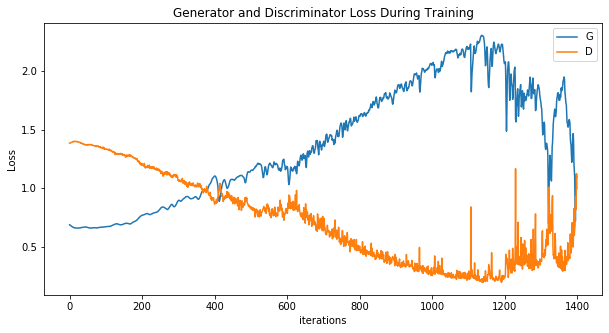

In [9]:
plot_train_loss()

# Animation

In [10]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

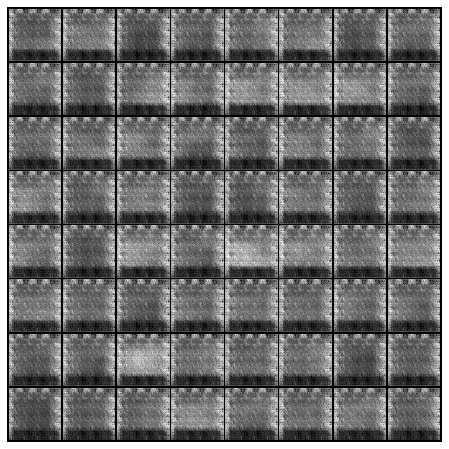

In [11]:
animate_gen_imgs()

# Anomaly Loss

In [12]:
latent_vector = torch.randn(1, latent_size, 1, 1, device = device, requires_grad=True)

def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    _, Test_Data_feature = D(Test_Data)
    _, G_Data_feature = D(G_Data)
    residual_loss = torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss = torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

z_optimizer = torch.optim.Adam([latent_vector],lr=0.01,betas=(0.5, 0.999))


test_data_root = "../../OhSeHyeon/source/dataset/test/test_CFRP"
# test_data_root = "../../dataset/test/test_DualPhaseSteel"
test_data_set = dataset.ImageFolder(root = test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))


# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# Train Latent Space Z

In [13]:
latent_space = []
auc=[]

def train_latent_space():
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data = G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step == 400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss > 500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [14]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

picture  1
[0]	 Ano_loss : 1655.7136  Sum_of_z : 1.9687
[200]	 Ano_loss : 1629.2826  Sum_of_z : -18.3841
[400]	 Ano_loss : 1622.6346  Sum_of_z : -18.0161
picture  2
[0]	 Ano_loss : 753.4429  Sum_of_z : -18.2172
[200]	 Ano_loss : 682.0738  Sum_of_z : -13.8151
[400]	 Ano_loss : 678.5539  Sum_of_z : -5.6493
picture  3
[0]	 Ano_loss : 894.0693  Sum_of_z : -5.5889
[200]	 Ano_loss : 857.3314  Sum_of_z : -12.5270
[400]	 Ano_loss : 855.1345  Sum_of_z : -10.3560
picture  4
[0]	 Ano_loss : 1084.5181  Sum_of_z : -10.6706
[200]	 Ano_loss : 1065.9010  Sum_of_z : 3.0734
[400]	 Ano_loss : 1064.4674  Sum_of_z : 0.1577
picture  5
[0]	 Ano_loss : 1134.4558  Sum_of_z : 0.4060
[200]	 Ano_loss : 1111.1681  Sum_of_z : 13.9398
[400]	 Ano_loss : 1110.7958  Sum_of_z : 14.7539
picture  6
[0]	 Ano_loss : 1094.5673  Sum_of_z : 14.7298
[200]	 Ano_loss : 1077.6790  Sum_of_z : 11.2711
[400]	 Ano_loss : 1076.6320  Sum_of_z : 9.2093
picture  7
[0]	 Ano_loss : 1394.7983  Sum_of_z : 9.5447
[200]	 Ano_loss : 1321.0000  S

[200]	 Ano_loss : 1372.5037  Sum_of_z : -16.9014
[400]	 Ano_loss : 1370.5131  Sum_of_z : -17.6128
picture  55
[0]	 Ano_loss : 901.4145  Sum_of_z : -17.5363
[200]	 Ano_loss : 855.1754  Sum_of_z : 1.1106
[400]	 Ano_loss : 852.6628  Sum_of_z : 1.7417
picture  56
[0]	 Ano_loss : 1958.3883  Sum_of_z : 1.5682
[200]	 Ano_loss : 1919.2377  Sum_of_z : -28.1660
[400]	 Ano_loss : 1916.6343  Sum_of_z : -31.0163
picture  57
[0]	 Ano_loss : 1967.6783  Sum_of_z : -31.0636
[200]	 Ano_loss : 1939.2515  Sum_of_z : -6.8349
[400]	 Ano_loss : 1936.9009  Sum_of_z : -0.7805
picture  58
[0]	 Ano_loss : 2233.4185  Sum_of_z : -1.0892
[200]	 Ano_loss : 2196.9309  Sum_of_z : -31.8550
[400]	 Ano_loss : 2196.1897  Sum_of_z : -30.0617
picture  59
[0]	 Ano_loss : 2281.1804  Sum_of_z : -30.0478
[200]	 Ano_loss : 2280.9941  Sum_of_z : -28.4972
[400]	 Ano_loss : 2280.9272  Sum_of_z : -27.5899
picture  60
[0]	 Ano_loss : 868.7570  Sum_of_z : -27.6573
[200]	 Ano_loss : 860.2036  Sum_of_z : -27.5776
[400]	 Ano_loss : 857.2

---

# 이상 픽셀 수 확인 함수

In [15]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

# Similar Z , Ano_Score and Segementation


In [16]:
diff_cnts = []
diff_points = []
anomaly_imgs = []


def compare_imgs(real_img, generated_img, i, reverse=False, threshold=50):
    global anomaly_img
    
    score = Anomaly_loss(real_img, generated_img)
    score = round(score.item(), 2)
    
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    negative = np.zeros_like(real_img)
    
    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img
    diff_img[diff_img <= threshold] = 0
    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    # 분산 추출
    diff_points.append(np.where(diff_img > threshold))
    
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)
    # anomaly_img 추출
    anomaly_imgs.append(anomaly_img)
    
    fig, plots = plt.subplots(1, 4)
    if auc[i] == 0:
        fig.suptitle(f'Normal - (anomaly score: {score:.4})')
    else :
        fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')

/home/piai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


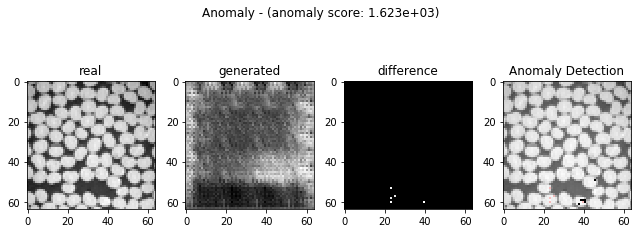

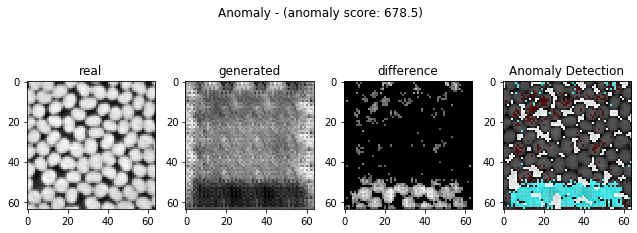

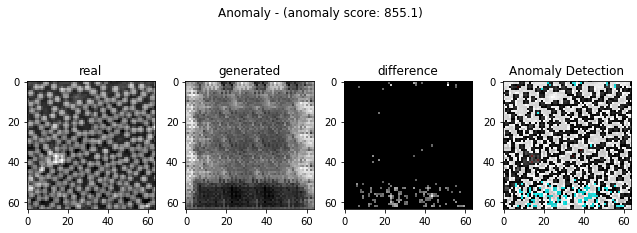

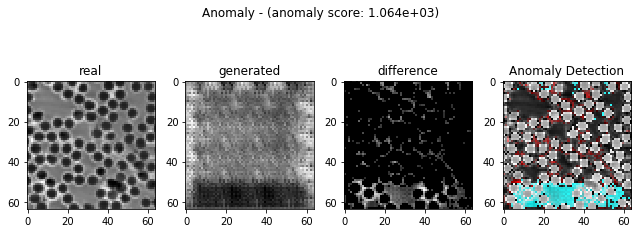

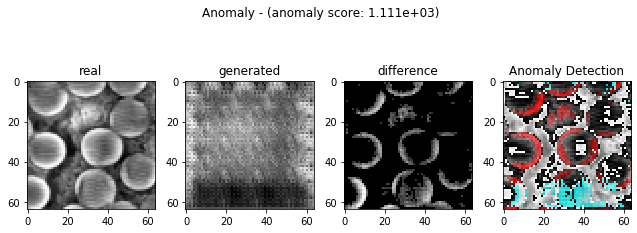

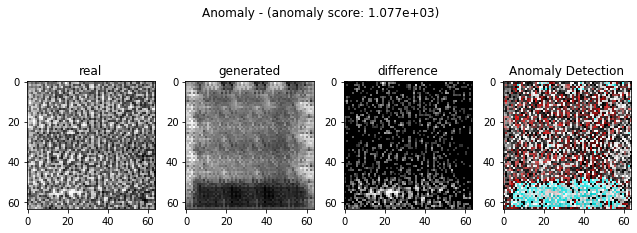

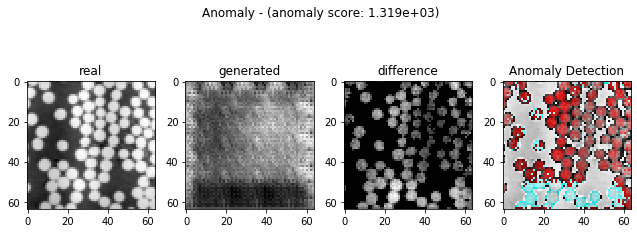

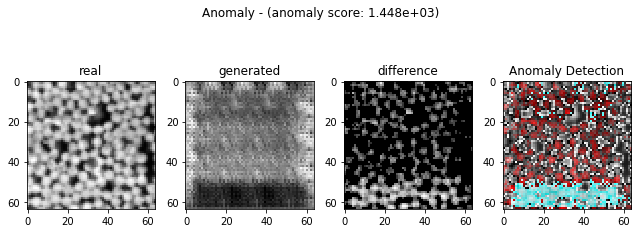

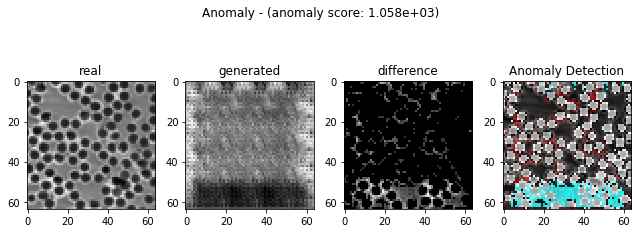

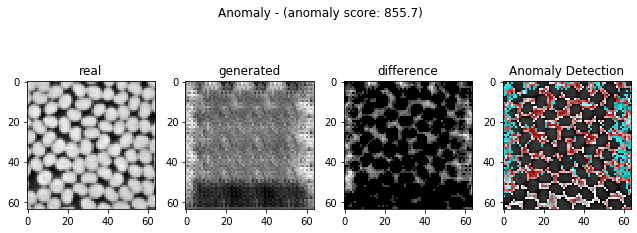

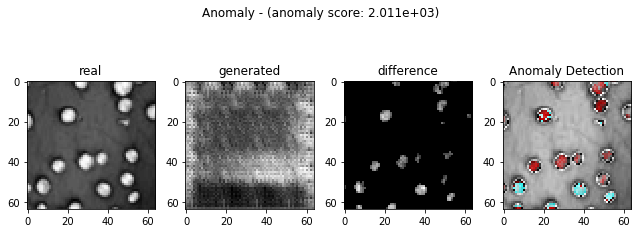

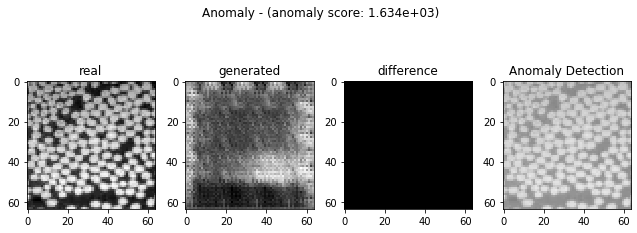

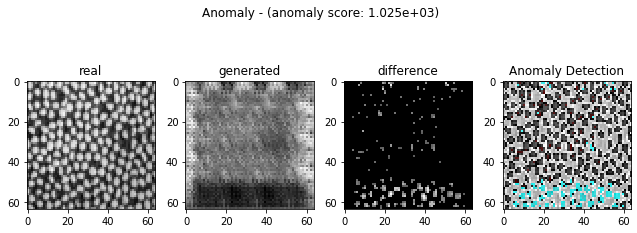

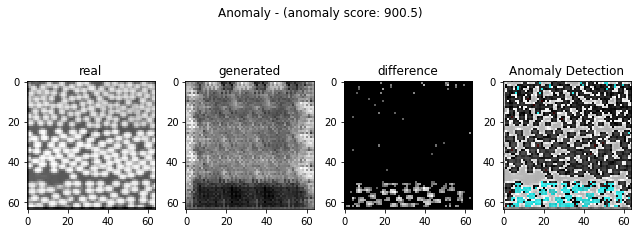

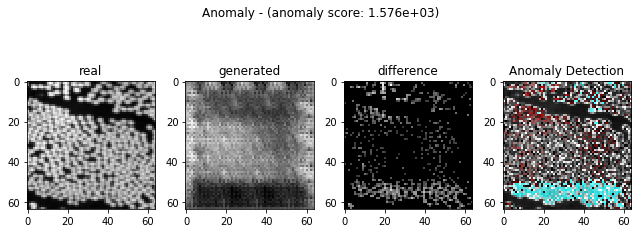

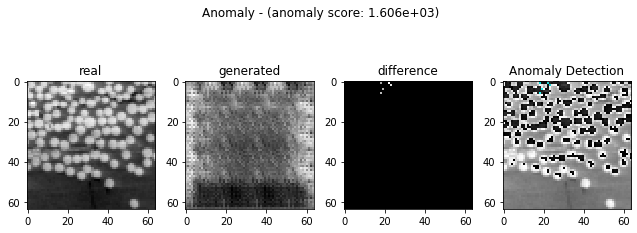

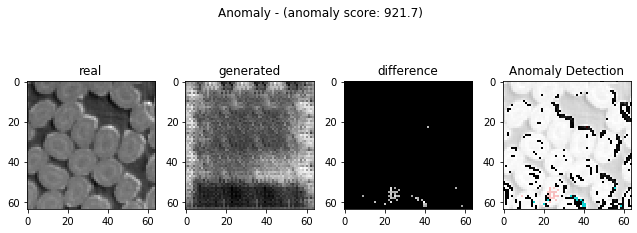

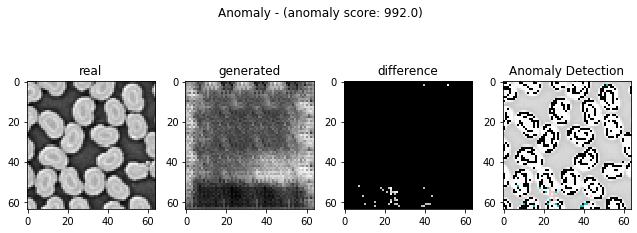

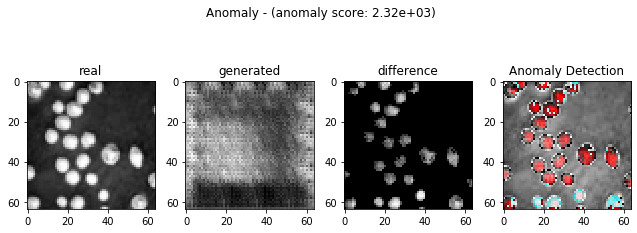

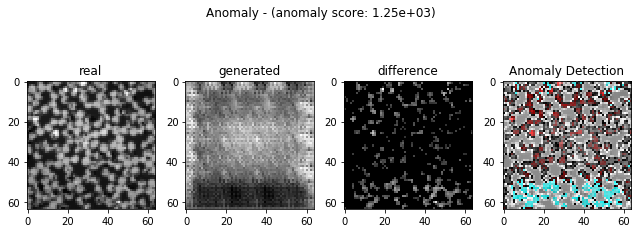

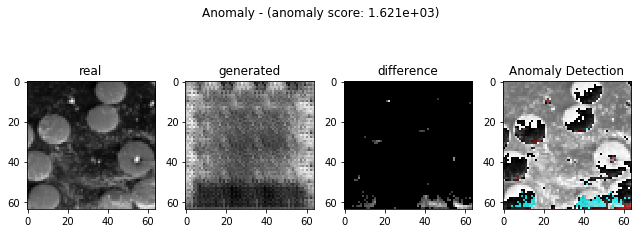

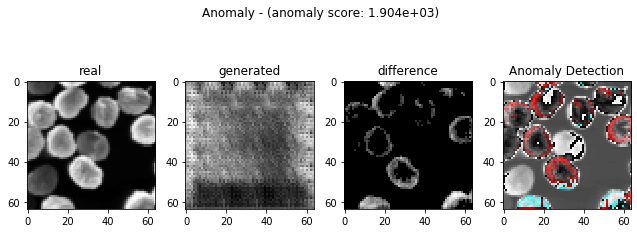

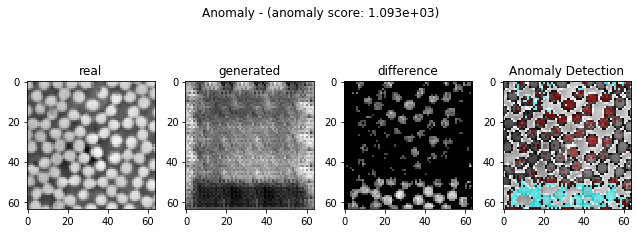

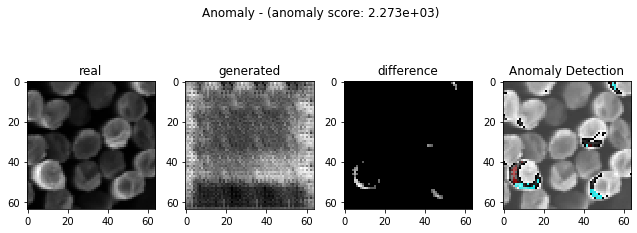

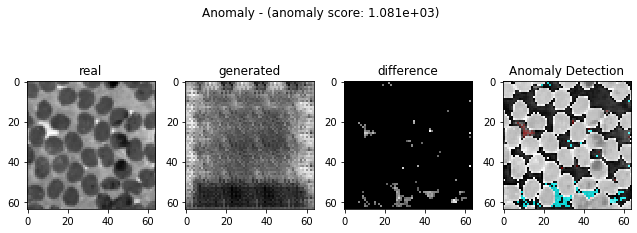

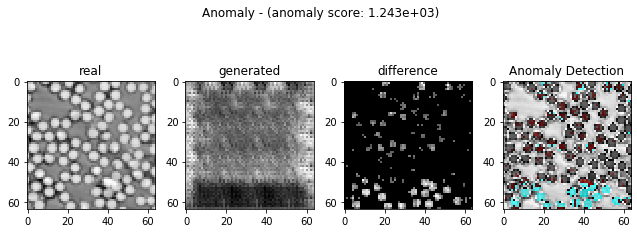

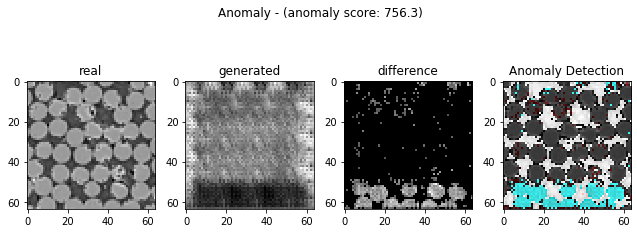

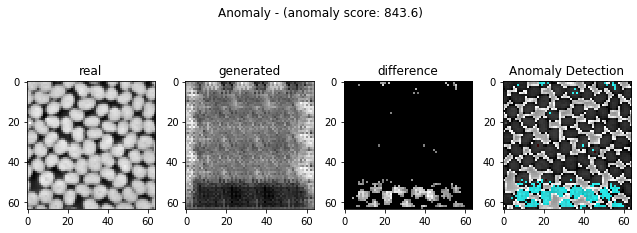

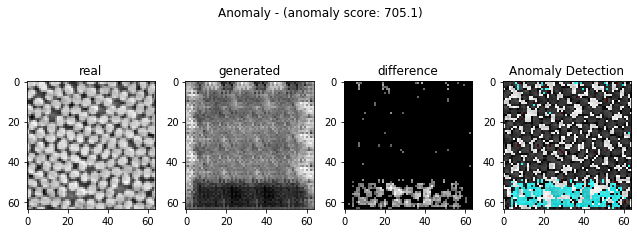

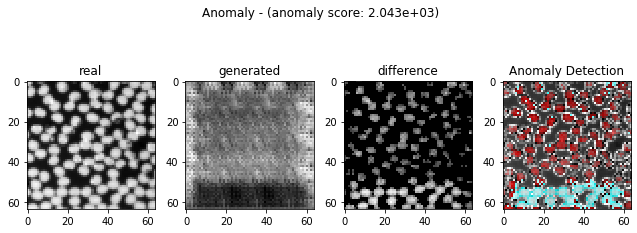

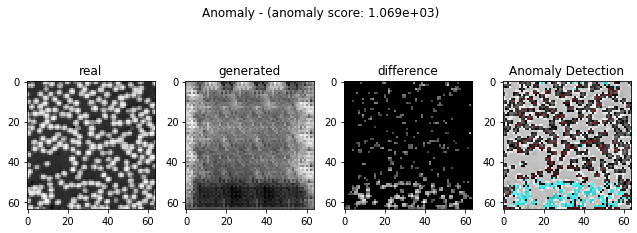

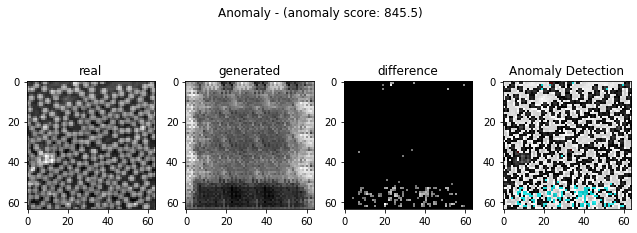

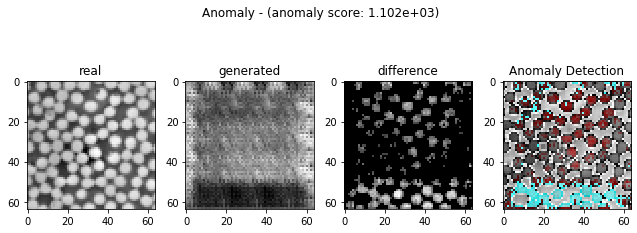

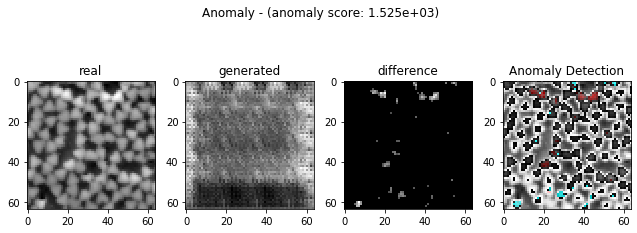

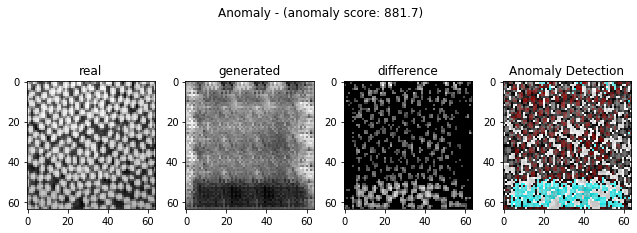

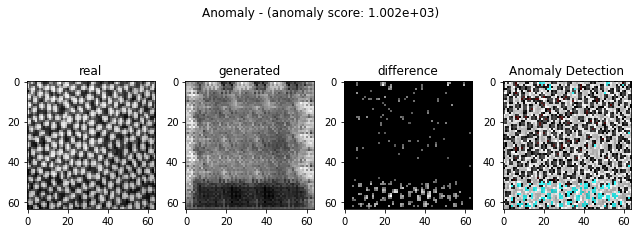

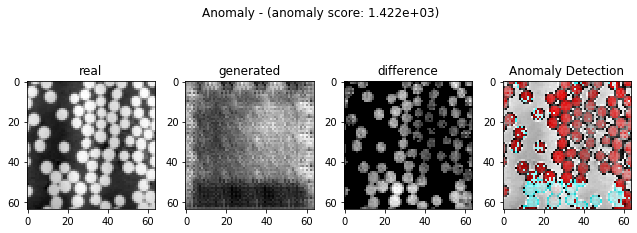

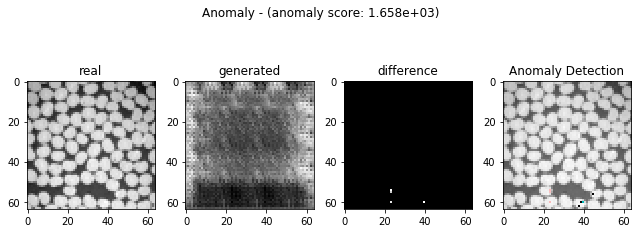

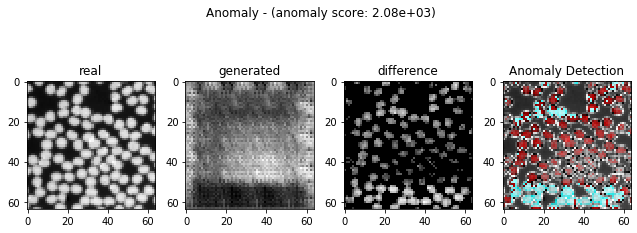

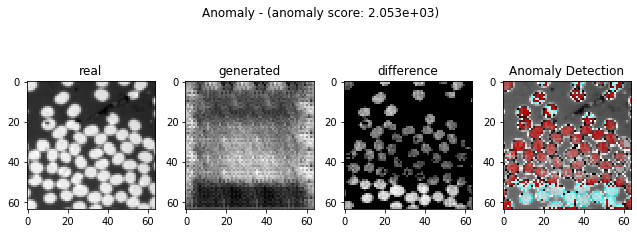

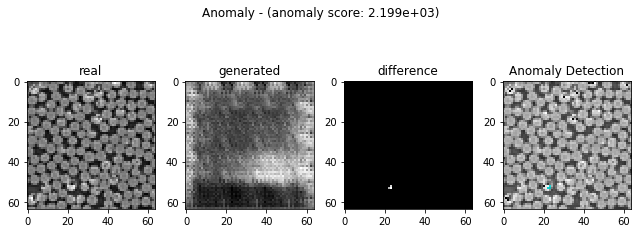

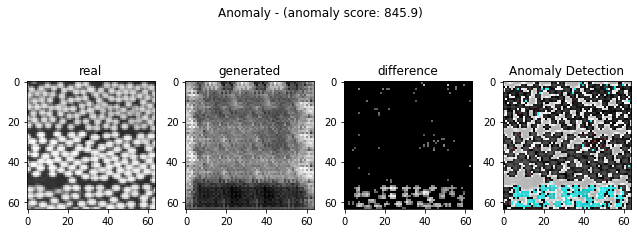

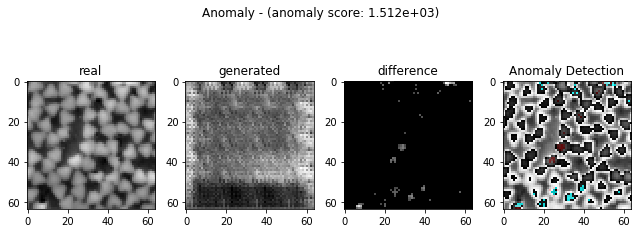

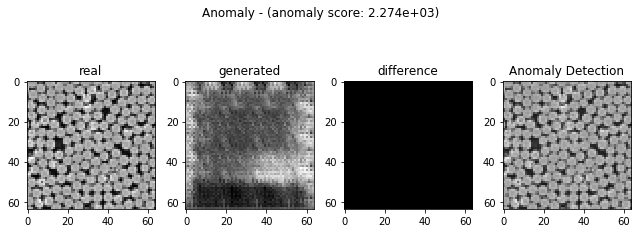

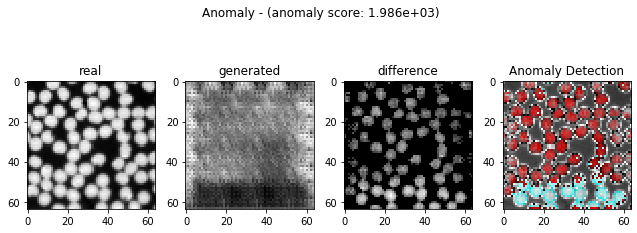

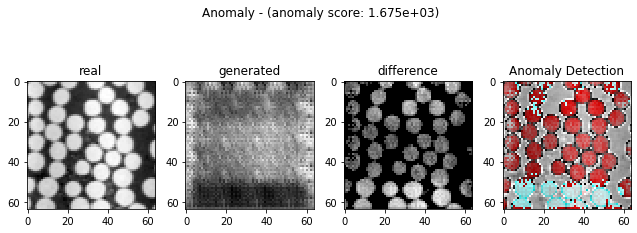

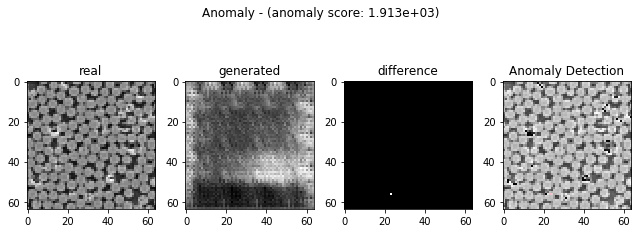

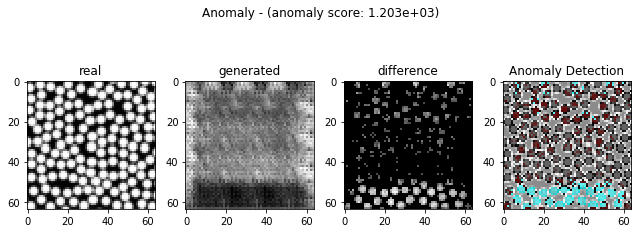

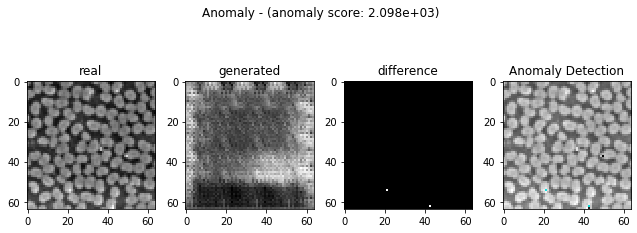

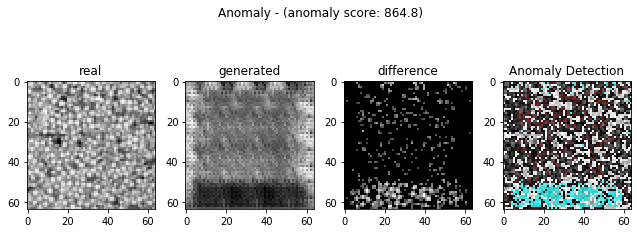

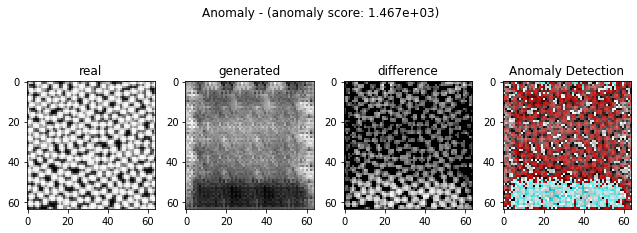

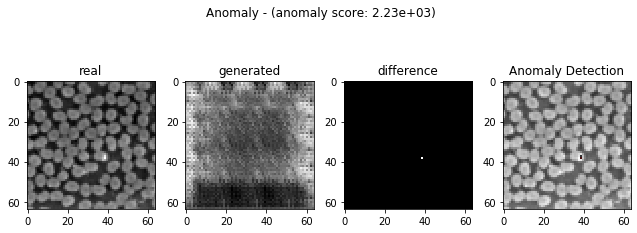

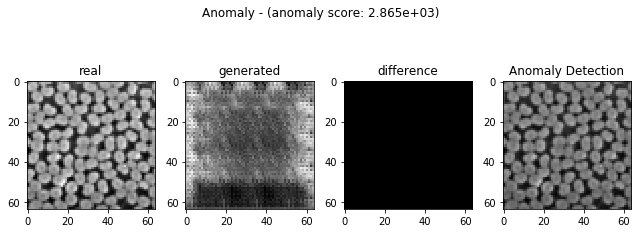

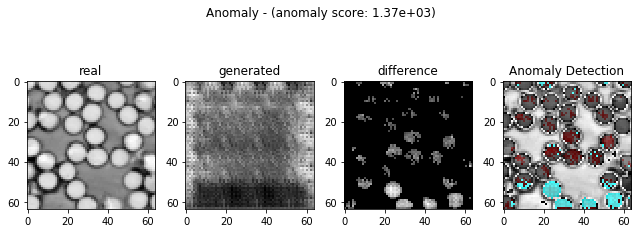

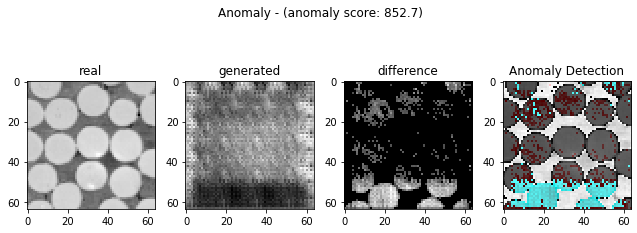

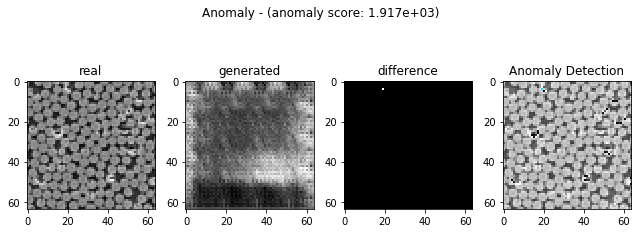

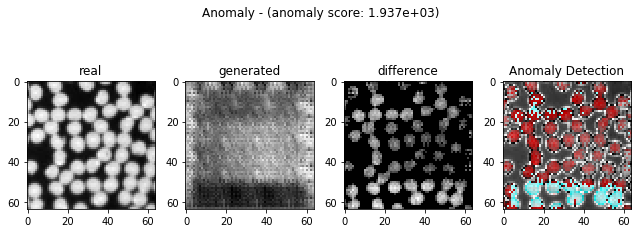

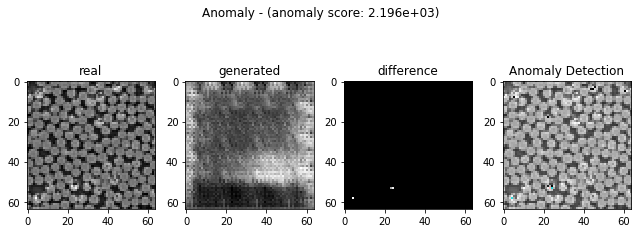

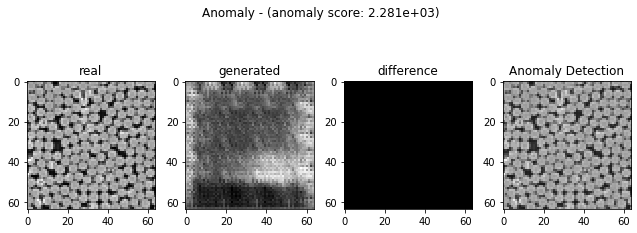

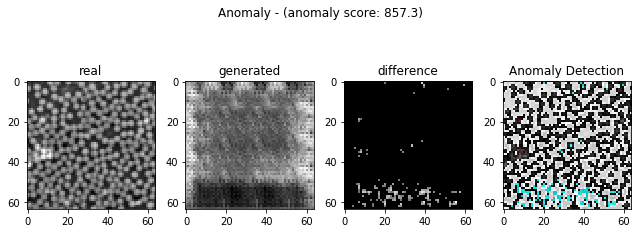

In [17]:
for i,data in enumerate(test_data_loader,0):
    test_img = data[0].to(device)

    #for i in range(len(latent_space)):
    update_z = latent_space[i]
    R_img = test_img
    G_img = G(update_z).to(device)
    
    if i in [9]:
        compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
    else:
        compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

---

# 분율 추출

In [18]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.42504883 0.46313477 0.04492188 0.23583984 0.         0.05004883
 0.29736328]


---

# 분산 추출

In [18]:
from scipy import stats
from extended_int import int_inf

corr_coeffis = []
corr_p_vals = []

def cal_corr_coeffis():
    for idx in range(len(test_data_loader)):
        x_points = diff_points[idx][0]
        y_points = diff_points[idx][1]
        
        
        if len(x_points) > 0:
            corr_coeffi, corr_p_val = stats.pearsonr(x_points, y_points)
        else:
            corr_coeffi, corr_p_val = -int_inf, -int_inf
        
        corr_coeffis.append(corr_coeffi)
        corr_p_vals.append(corr_p_val)

ModuleNotFoundError: No module named 'extended_int'

In [ ]:
cal_corr_coeffis()

print(corr_coeffis)

---

# 모델 저장 및 읽기

In [21]:
save_file = "./pretrained/pretrained.pth"

def save_pretrained():
    pretrained = {
        "D" : D.state_dict(),
        "G" : G.state_dict(),
        #"latent_space" : latent_space.state_dict(), # nn.model만 가지는 기능
    }

    if not os.path.isdir("pretrained"):
        os.mkdir("pretrained")
    torch.save(pretrained, save_file)

In [22]:
save_pretrained()

In [23]:
pretrained_D = Discriminator().to(device)
pretrained_G = Generator().to(device)
#pretrained_latent_space = [] # 다시 학습해야 함

def load_pretrained():
    global pretrained_D
    global pretrained_G
    #global pretrained_latent_space
    
    assert os.path.isdir("pretrained"), "Error : no pretrained dir found!"
    
    pretrained = torch.load(save_file)
    
    pretrained_D.load_state_dict(pretrained["D"])
    pretrained_G.load_state_dict(pretrained["G"])
    #pretrained_latent_space.load_state_dict(pretrained["latent_space"])
    
    #print("pretrained_D :", pretrained_D)
    #print("pretrained_G :", pretrained_G)
    #print("pretrained_latent_space :", pretrained_latent_space)

In [24]:
load_pretrained()

In [25]:
def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    
    _, Test_Data_feature = pretrained_D(Test_Data)
    _, G_Data_feature = pretrained_D(G_Data)
    residual_loss = torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss = torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

In [26]:
# train latent_space

latent_space = []
auc = []

def train_latent_space():
    global latent_space
    global auc
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data   = pretrained_G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step==400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss>500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [27]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

picture  1
[0]	 Ano_loss : 1266.3403  Sum_of_z : -3.3242
[200]	 Ano_loss : 1264.7040  Sum_of_z : 0.9610
[400]	 Ano_loss : 1264.6361  Sum_of_z : 1.0947
picture  2
[0]	 Ano_loss : 1201.3168  Sum_of_z : 1.3532
[200]	 Ano_loss : 1199.7808  Sum_of_z : 11.9149
[400]	 Ano_loss : 1199.6984  Sum_of_z : 12.8498
picture  3
[0]	 Ano_loss : 1015.5364  Sum_of_z : 12.9203
[200]	 Ano_loss : 1013.7377  Sum_of_z : 6.7273
[400]	 Ano_loss : 1013.6226  Sum_of_z : -1.5176
picture  4
[0]	 Ano_loss : 524.4009  Sum_of_z : -1.5813
[200]	 Ano_loss : 523.0158  Sum_of_z : -6.6464
[400]	 Ano_loss : 522.9283  Sum_of_z : -4.0442
picture  5
[0]	 Ano_loss : 1090.5264  Sum_of_z : -4.1989
[200]	 Ano_loss : 1090.0314  Sum_of_z : -11.3059
[400]	 Ano_loss : 1090.0150  Sum_of_z : -12.8962
picture  6
[0]	 Ano_loss : 345.9109  Sum_of_z : -12.8769
[200]	 Ano_loss : 344.4709  Sum_of_z : 4.4213
[400]	 Ano_loss : 344.2828  Sum_of_z : 12.5208
picture  7
[0]	 Ano_loss : 671.7592  Sum_of_z : 12.4988
[200]	 Ano_loss : 670.0259  Sum_of

In [28]:
def test():
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)

        #for i in range(len(latent_space)):
        update_z = latent_space[i]
        R_img = test_img
        G_img = pretrained_G(update_z).to(device)

        if i in [9]:
            compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
        else:
            compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

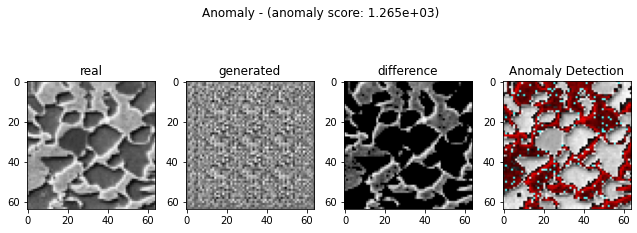

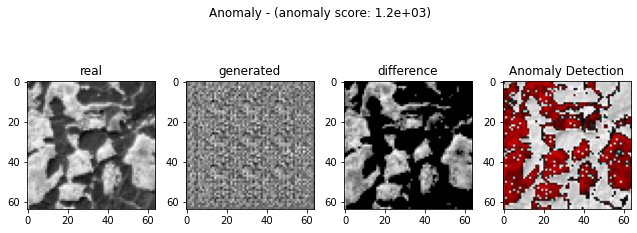

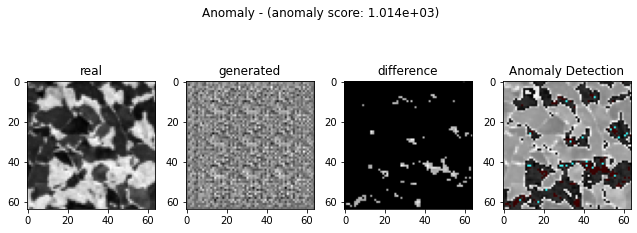

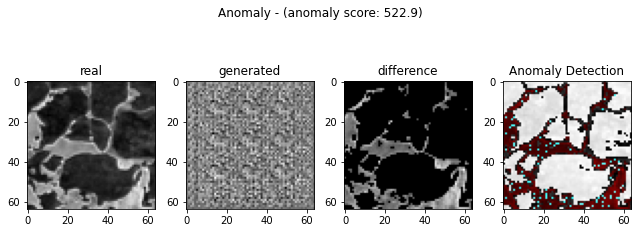

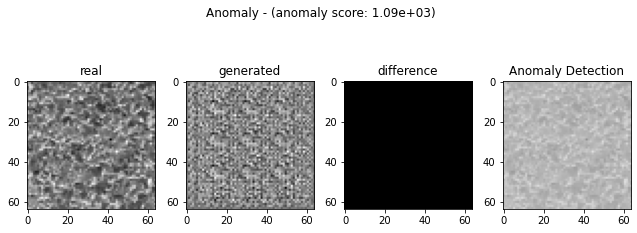

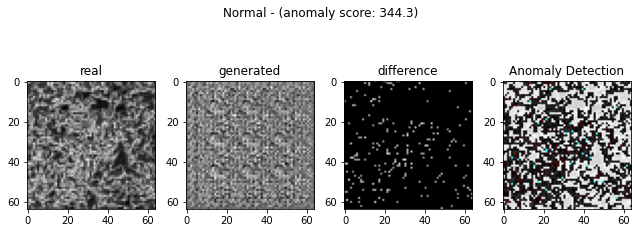

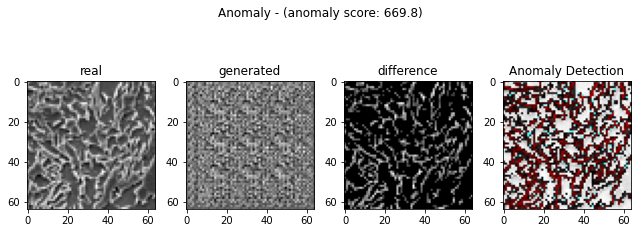

In [29]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

corr_coeffis = []
corr_p_vals = []

test()

In [30]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.42578125 0.46264648 0.04516602 0.2355957  0.         0.04980469
 0.29760742]


In [31]:
cal_corr_coeffis()

print(corr_coeffis)

[0.03930323451955458, 0.09824271107967668, -0.28914111459826475, 0.19809595979534306, -inf, 0.04507935167666852, -0.08497257982755216]


---

# anomaly detection 이미지 추출

In [32]:
anomaly_imgs

[array([[[242, 242, 242],
         [246, 246, 246],
         [121,   0,   0],
         ...,
         [210, 210, 210],
         [176, 176, 176],
         [222, 222, 222]],
 
        [[248, 248, 248],
         [242, 242, 242],
         [ 87,   1,   1],
         ...,
         [238, 238, 238],
         [238, 238, 238],
         [190, 190, 190]],
 
        [[236, 236, 236],
         [230, 230, 230],
         [ 77,   3,   3],
         ...,
         [230, 230, 230],
         [232, 232, 232],
         [238, 238, 238]],
 
        ...,
 
        [[230, 230, 230],
         [248, 248, 248],
         [212, 212, 212],
         ...,
         [142, 142, 142],
         [ 85,  85,  85],
         [130, 130, 130]],
 
        [[228, 228, 228],
         [244, 244, 244],
         [230, 230, 230],
         ...,
         [105, 105, 105],
         [150, 150, 150],
         [252, 252, 252]],
 
        [[218, 218, 218],
         [228, 228, 228],
         [246, 246, 246],
         ...,
         [182, 182, 182],
  

# 이미지 저장 함수

In [33]:
import cv2

def save_imgs(folder, imgs):
    if not os.path.isdir("anomaly_imgs"):
        os.mkdir("anomaly_imgs")
    
    for i in range(len(imgs)):
        cv2.imwrite('%s/%d.png' %(folder,i), imgs[i]) #이미지 저장할 경로 설정을 여기서 한다.
    print("image saving complete")

In [34]:
save_imgs("./anomaly_imgs", anomaly_imgs)

image saving complete


---

# 티타늄(Ti64) 상대 밀도 계산

In [35]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)

[1.88621094 2.04952393 0.20008545 1.04368896 0.         0.22063477
 1.31840088]
